### Benchmarking ensemble generation

This notebook does some simple benchmarking of ensemble generation in Medusa through iterative gapfilling. You can see the full narrative version of the process being benchmarked in the  [**Creating an ensemble**](https://medusa.readthedocs.io/en/latest/creating_ensemble.html) section of the User Guide.

In [5]:
# Load the test model for Staphylococcus aureus, originally generated with ModelSEED
import medusa
from medusa.test import create_test_model
model = create_test_model('Saureus_seed')

# Load the biolog data from Plata et al., Nature 2014
from medusa.test import load_biolog_plata
biolog_base_composition, biolog_base_dict, biolog_thresholded = load_biolog_plata()

# Extract growth/no growth calls for staph aureus
test_mod_pheno = biolog_thresholded.loc['Staphylococcus aureus']
test_mod_pheno = list(test_mod_pheno[test_mod_pheno == True].index)

# load the universal reaction database
from medusa.test import load_universal_modelseed
from cobra.core import Reaction
universal = load_universal_modelseed()

# check for biolog base components in the model and record
# the metabolites/exchanges that need to be added
add_mets = []
add_exchanges = []
for met in list(biolog_base_dict.keys()):
    try:
        model.metabolites.get_by_id(met)
    except:
        print('no '+met)
        add_met = universal.metabolites.get_by_id(met).copy()
        add_mets.append(add_met)

model.add_metabolites(add_mets)

for met in list(biolog_base_dict.keys()):
    # Search for exchange reactions
    try:
        model.reactions.get_by_id('EX_'+met)
    except:
        add_met = universal.metabolites.get_by_id(met)
        ex_rxn = Reaction('EX_' + met)
        ex_rxn.name = "Exchange reaction for " + met
        ex_rxn.lower_bound = -1000
        ex_rxn.upper_bound = 1000
        ex_rxn.add_metabolites({add_met:-1})
        add_exchanges.append(ex_rxn)

model.add_reactions(add_exchanges)

# Find metabolites from the biolog data that are missing in the test model
# and add them from the universal
missing_mets = []
missing_exchanges = []
media_dicts = {}
for met_id in test_mod_pheno:
    try:
        model.metabolites.get_by_id(met_id)
    except:
        print(met_id + " was not in model, adding met and exchange reaction")
        met = universal.metabolites.get_by_id(met_id).copy()
        missing_mets.append(met)
        ex_rxn = Reaction('EX_' + met_id)
        ex_rxn.name = "Exchange reaction for " + met_id
        ex_rxn.lower_bound = -1000
        ex_rxn.upper_bound = 1000
        ex_rxn.add_metabolites({met:-1})
        missing_exchanges.append(ex_rxn)
    media_dicts[met_id] = biolog_base_dict.copy()
    media_dicts[met_id] = {'EX_'+k:v for k,v in media_dicts[met_id].items()}
    media_dicts[met_id]['EX_'+met_id] = 1000
model.add_metabolites(missing_mets)
model.add_reactions(missing_exchanges)

no cpd00013_e
cpd11594_e was not in model, adding met and exchange reaction
cpd05158_e was not in model, adding met and exchange reaction
cpd15584_e was not in model, adding met and exchange reaction
cpd00492_e was not in model, adding met and exchange reaction
cpd00232_e was not in model, adding met and exchange reaction
cpd19001_e was not in model, adding met and exchange reaction
cpd00709_e was not in model, adding met and exchange reaction
cpd00396_e was not in model, adding met and exchange reaction
cpd01307_e was not in model, adding met and exchange reaction
cpd00079_e was not in model, adding met and exchange reaction
cpd00072_e was not in model, adding met and exchange reaction
cpd00320_e was not in model, adding met and exchange reaction
cpd01293_e was not in model, adding met and exchange reaction
cpd05264_e was not in model, adding met and exchange reaction
cpd03561_e was not in model, adding met and exchange reaction
cpd00094_e was not in model, adding met and exchange rea

With the input prepared, let's fill some gaps using the `iterative_gapfill_from_binary_phenotypes` function. We will gapfill each ensemble using 10 media conditions and perform the process three times for target ensemble sizes of 5 members, 25 members, and 100 members. Each ensemble generation step will be repeated 10 times with a different random sampling of 10 media conditions (e.g., 10 ensembles of 5 members, 25 members and 100 members will be generated and the mean/standard deviation of construction time will be reported).

In [19]:
from medusa.reconstruct.expand import iterative_gapfill_from_binary_phenotypes
import time
import random

num_cycles = 5
lower_bound = 0.05
flux_cutoff = 1E-10

clock_time = {}
clock_time[5] = []
for i in range(0,10):
    # sample without replacement
    media_selection = random.sample(list(media_dicts.keys()),10)
    sub_dict = {condition:media_dicts[condition] for condition in media_selection}
    time1 = time.time()
    ensemble = iterative_gapfill_from_binary_phenotypes(model,universal,sub_dict,num_cycles,\
                                     lower_bound=lower_bound,\
                                     inclusion_threshold=1E-10,\
                                     exchange_reactions=False,\
                                     demand_reactions=False,\
                                     exchange_prefix='EX');
    time2 = time.time()
    clock_time[5].append(time2-time1)
    print("Clock time: " + str(time2-time1))

num_cycles = 25
clock_time[25] = []
for i in range(0,10):
    # sample without replacement
    media_selection = random.sample(list(media_dicts.keys()),10)
    sub_dict = {condition:media_dicts[condition] for condition in media_selection}
    time1 = time.time()
    ensemble = iterative_gapfill_from_binary_phenotypes(model,universal,sub_dict,num_cycles,\
                                     lower_bound=lower_bound,\
                                     inclusion_threshold=1E-10,\
                                     exchange_reactions=False,\
                                     demand_reactions=False,\
                                     exchange_prefix='EX');
    time2 = time.time()
    clock_time[25].append(time2-time1)
    print("Clock time: " + str(time2-time1))
    
num_cycles = 100
clock_time[100] = []
for i in range(0,10):
    # sample without replacement
    media_selection = random.sample(list(media_dicts.keys()),10)
    sub_dict = {condition:media_dicts[condition] for condition in media_selection}
    time1 = time.time()
    ensemble = iterative_gapfill_from_binary_phenotypes(model,universal,sub_dict,num_cycles,\
                                     lower_bound=lower_bound,\
                                     inclusion_threshold=1E-10,\
                                     exchange_reactions=False,\
                                     demand_reactions=False,\
                                     exchange_prefix='EX');
    time2 = time.time()
    clock_time[100].append(time2-time1)
    print("Clock time: " + str(time2-time1))

Constraining lower bound for bio1
starting cycle number 0
starting cycle number 1
starting cycle number 2
starting cycle number 3
starting cycle number 4
building features...
updating members...
Clock time: 97.85026526451111
Constraining lower bound for bio1
starting cycle number 0
starting cycle number 1
starting cycle number 2
starting cycle number 3
starting cycle number 4
building features...
updating members...
Clock time: 106.4863657951355
Constraining lower bound for bio1
starting cycle number 0
starting cycle number 1
starting cycle number 2
starting cycle number 3
starting cycle number 4
building features...
updating members...
Clock time: 119.81539511680603
Constraining lower bound for bio1
starting cycle number 0
starting cycle number 1
starting cycle number 2
starting cycle number 3
starting cycle number 4
building features...
updating members...
Clock time: 97.87515687942505
Constraining lower bound for bio1
starting cycle number 0
starting cycle number 1
starting cycle nu

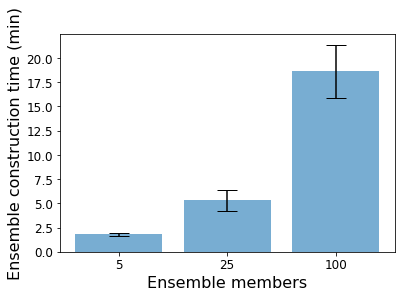

In [61]:
import matplotlib.pylab as plt
import numpy as np
fig,ax = plt.subplots()
clock_time_as_min = {t:[ti/60.0 for ti in clock_time[t]] for t in clock_time.keys()}
x = list(clock_time_as_min.keys())
x.sort()
ax.bar(x=[1,2,3],height=[np.mean(clock_time_as_min[time]) for time in x],
       yerr=[np.std(clock_time_as_min[time]) for time in x],
       capsize=10,alpha=0.6)
ax.set_xlabel('Ensemble members',size=16)
ax.set_ylabel('Ensemble construction time (min)',size=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.set(xticks=[1,2,3])
ax.set_xticklabels(labels=x)
plt.savefig('benchmark_iter_gapfill.svg')

In [63]:
# what are the mean values?
[np.mean(clock_time_as_min[time]) for time in x]

[1.789455144802729, 5.327363805770874, 18.61842150807381]

As you can see, ensemble size and construction time are fairly proportional. There is a large amount of time spent copying the universal model, so contructing the small 5-member ensemble takes longer than one might expect. A larger universal model will take longer to copy, and each gapfilling step will take longer if more media conditions are included.